In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
p = sm.Project.objects.get(pk=196)

In [3]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [4]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

In [5]:
print(len(ttweets))

117443


In [39]:
import pickle

pickle_out = open("ttweets.pickle","wb")
pickle.dump(ttweets, pickle_out)
pickle_out.close()

---

## Language from BaseModel

In [6]:
random.seed(123)
test_texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 1000)
).values_list('text', 'lang')

In [8]:
df_test = pd.DataFrame(list(test_texts), columns=['text', 'lang'])

In [10]:
df_test.to_csv("df_test.csv")

In [11]:
is_de = df_test["lang"]=="de"
df_de = df_test[is_de]

In [12]:
df_de

,text,lang
0,Mensch mit Kamera im #HambacherForst von der P...,de
2,es geht also los. Jetzt ist der Zeitpunkt geko...,de
3,1142 Leute haben es geschafft die Polizeikette...,de
6,+++Hambacher Rodungszeit+++ Neuer Film online!...,de
7,@sonntagsflo Das Vorgehen einiger passt da sch...,de
8,"Mi., 20.12. 19h #Klapperfeld #Frankfurt: #Hamb...",de
9,#hambacherforst #hambibleibt Danke an alle! Je...,de
10,Typische #RWE und #Polizei Logik. Die Barrikad...,de
11,16:14 Mensch aus der Tripodstruktur wird jetzt...,de
12,Eine schöne Soli-Aktion von @GegenstromHH heut...,de


In [13]:
df_de.to_csv('df_de.csv')

---

## Sentiment Analysis

### testing on small set

In [14]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [16]:
df_de.iloc[0]['text']

'Mensch mit Kamera im #HambacherForst von der Polizei niedergeknüppelt und festgenommen.#HambacherForstBleibt #HambiBleibt #HFB #DankePolizei'

In [17]:
doc = nlp(df_de.iloc[0]['text'])
for token in doc: 
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))

Mensch, None, NOUN
mit, None, ADP
Kamera, None, NOUN
im, None, ADP
#, None, NOUN
HambacherForst, None, PROPN
von, None, ADP
der, None, DET
Polizei, None, NOUN
niedergeknüppelt, None, VERB
und, None, CONJ
festgenommen.#HambacherForstBleibt, None, PROPN
#, None, NOUN
HambiBleibt, None, PROPN
#, None, NOUN
HFB, None, PROPN
#, None, PROPN
DankePolizei, None, NOUN


In [22]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(scores)
    else:
        return 0

In [23]:
get_senti_score(doc)

0

In [24]:
tweet_scores = []
for i in df_de.index:
    entry = df_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    tweet_scores.append(tweet_score)

In [25]:
df_de['score'] = tweet_scores
df_de

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,text,lang,score
0,Mensch mit Kamera im #HambacherForst von der P...,de,0.000000
2,es geht also los. Jetzt ist der Zeitpunkt geko...,de,0.004000
3,1142 Leute haben es geschafft die Polizeikette...,de,0.004000
6,+++Hambacher Rodungszeit+++ Neuer Film online!...,de,0.004000
7,@sonntagsflo Das Vorgehen einiger passt da sch...,de,-0.340900
8,"Mi., 20.12. 19h #Klapperfeld #Frankfurt: #Hamb...",de,0.000000
9,#hambacherforst #hambibleibt Danke an alle! Je...,de,0.494000
10,Typische #RWE und #Polizei Logik. Die Barrikad...,de,0.371600
11,16:14 Mensch aus der Tripodstruktur wird jetzt...,de,0.000000
12,Eine schöne Soli-Aktion von @GegenstromHH heut...,de,0.008100


In [28]:
df_de.to_csv("df_de_scores2.csv")

In [26]:
most_neg = df_de.sort_values(by=['score'])[0:5]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

#Bundesregierung #RWE #19sept2018 für #Hambibleibt Journalist bricht durch 1 Hängebrücke als Polizisten mit räumen begannen! :( https://t.co/7RNZGNHf4f
Sacht ma @ArminLaschet , @hreul und @Polizei_NRW_AC ,
irgendwie haben sich bei Euch doch die Prioritäten sehr bedenklich verschoben ..,
Der Junge ist 6!
Aber #Nazis dürfen in #Dortmund machen, was sie wollen ..

#HambacherForst
#HambiBleibt https://t.co/lO3J4GQuNj
@KathrinAnna Jeder der vor Ort ist, sieht es.

Seit Monaten wird darauf hingewiesen, dass das Heranrücken der Bagger auf 50m den #HambacherForst gefährdet. 

Aber die Landesregierung lässt RWE gewähren und verleugnet die Gefahr, die für den Wald entsteht.
Verlogener geht es kaum.
#HambiBleibt
https://t.co/Hon60q6QpE die Umweltverbrecher von #RWE heulen jetzt auch noch kindisch herum. Ihr seid total lächerlich. Für eure Insolvenz stelle ich mir jede Menge Champus kalt.. #Mimimi #HambacherForst #Hambibleibt
bei diesem wetter auf waldboden hubsteiger aufstellen zu wollen halte ic

In [27]:
most_pos = df_de.sort_values(by=['score'], ascending=False)[0:5]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

#HambacherForst #Hambibleibt https://t.co/PAZuNifsls Nach der Europawahl sind in NRW nur die Grünen euphorisch - NRZ News
@revomage @JennyD35311900 Ist bestimmt auch toll, die Neuigkeiten - dich selbst betreffend - vom Kollegen zu erfahren 🙄

#HambacherForst #Hambibleibt #NoPolGNRW
Super Stimmung bei der @EndeGelaendeLE Demo! 

#stopcoal #hambibleibt #FridaysForFuture #Kohleausstieg https://t.co/MyoPzLRZTN
Die Rede ist super, aber es ist zum Kotzen, dass der Saal mal wieder halb voll ist und die meisten lesen oder auf ihr Handy starren. So kann keine Politik für das Volk gemacht werden. #CDU #SPD #HambacherForst #hambibleibt https://t.co/VED4CjqN9h
#RWE Hetze widerlich! #HambacherForst #HambiBleibt Feiert Weihnachten ihr Spacken!!! https://t.co/Wpr1Q7ZQHh


---

### actual

In [29]:
texts = tm.Status.objects.filter(
    id__in=ttweets
).values_list('text', 'lang')

In [31]:
df_texts = pd.DataFrame(list(texts), columns=['text', 'lang'])

In [33]:
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

In [35]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [36]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
texts_de.to_csv('texts_de.csv')

In [38]:
texts_de.head()

,text,lang,score
1,Im #HambacherForst sollen 14 AktivistInnen in...,de,0.004
2,Respekt! http://t.co/XJQNOirzV8 #hambibleibt #...,de,0.004
3,"SpiegelTV und ""Die Rächer vom Hambach Forrest""...",de,0.000
4,Im #HambacherForst wurde eine bewohnte Barrika...,de,0.004
5,#Solidarität mit den BesetzerInnen vom @Hambac...,de,0.004


In [48]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.014064564744962675

<Figure size 432x288 with 0 Axes>

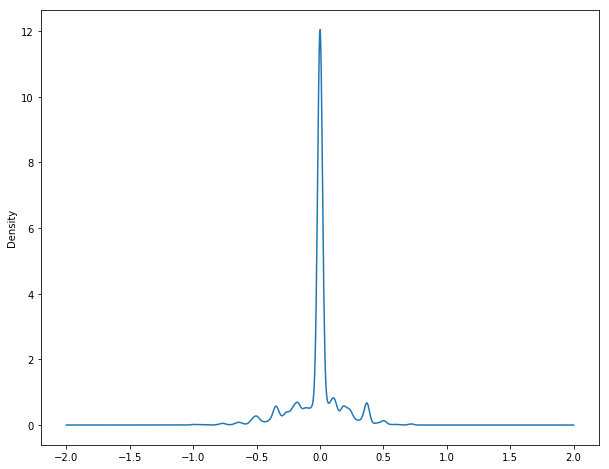

<Figure size 432x288 with 0 Axes>

In [45]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.kde()

plt.figure()

<Figure size 432x288 with 0 Axes>

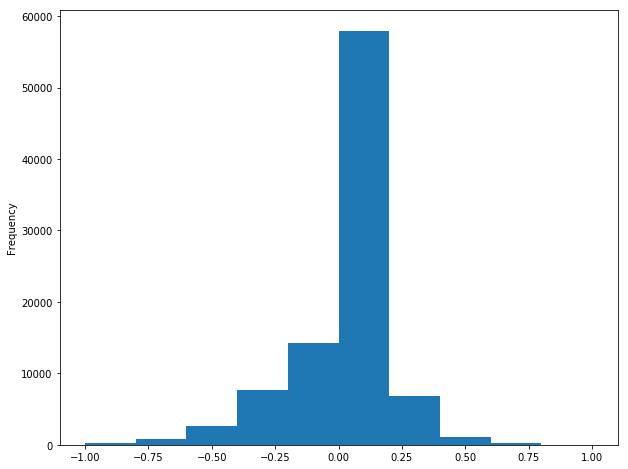

<Figure size 432x288 with 0 Axes>

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist()

plt.figure()

In [40]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

#HambacherForst #Hambibleibt https://t.co/uUBOs2lkrU Archiv für alternatives Schrifttum in Duisburg - "Gegenüberlieferung" in Gefahr - Deutschlandfunk
Verfolgen Sie den ganzen ersten #WaldSpaziergang live mit all seinen Aktionen und betreten Sie nun den #Hambacherforst (immer noch Gefahr von Rodung).
#AlleDörferBleiben #HambiBleibt #ExtinctionRebellion #FridaysForFuture #EndeGelände
https://t.co/8wCCvh7jUP via @YouTube
@Rembrandt1405 @Umweltgutachter @DieGutenNbg @csommer @spd_fraktion_nw Bitte? Was sind die denn schon gegen die drohende Gefahr eines #Ökomob|s 🧐

#hambacherforst #hambacherwald #hambibleibt
#HambacherForst #Hambibleibt https://t.co/bfMaewod37 Polizeichef: Derzeit keine „reale Gefahr“ für den Hambacher Forst - Aachener Nachrichten
18:47 Die #Polizei bringt Menschen  in Lorien in Gefahr, wir bitten die #Presse nach Lorien zu kommen! 
#HambacherForst 
#Hambibleibt
@JohannNeuge Ohne Hitlergruß sehe ich da kaum Chancen. Wie soll die #Pegizei sonst erkennen, dass von euch kei

In [41]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

JETZT gelungene, untendenziöse Doku zum #HambacherForst im @WDR Fernsehen "Bäume oder Braunkohle" 
#Hambi #hambibleibt
#Karlsruhe tanzt für den #Kohleausstieg! Was für ein Gelungener Tag. #EndeGelaende #hambibleibt! @Ende__Gelaende #KoKolores https://t.co/p42aT70Y4S
Danke Edwin Kronschnabel für die gelungene Satire! @KronschnabelMV (Das Landesamt für Besoldung NRW zahlt für die und für mich, schon lustig. Und das Ministergehalt von @hreul. Bitter. #hambibleibt ) https://t.co/ZnlpbPn5sI
Nach einem gelungen Aktionstraining, gibt es jetzt erstmal KÜFA und um 16.30 eine #HambiBleibt Demo in #Aachen. #AktionUnterholz #stopcoal #EndeGelände https://t.co/FmvnFlYJhc
Ein sehr gelungener Thread über den #Hambi, die Besetzung, Ideale etc #hambibleibt #HambacherForst https://t.co/mgqXolG1Sv
Gelungene Premiere in Fürth - Danke @FridaysForFut12 
#FridaysForFurture #ParentsForFuture #ScientistsForFuture #alledörferbleiben #hambibleibt https://t.co/PcC7htJMSF
So wird der Samstag der perfekten Demotag.